<a href="https://colab.research.google.com/github/leeminseo0809/study/blob/master/multilayer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Multilayer Perceptron (Torch-Implementation)**

A multilayer perceptron is a special case of a feed-forward neural network where every layer is a fully connected layer.

\
In this particular instance, we define the dimensions of $x$ and $y$ to be $dim(x)=2$ and $dim(y)=1$, respectively.

The architecture of the feed-forward neural network is depicted below.
 <p align="center"><img src='https://drive.google.com/uc?export=download&id=1iWM3C4HHSzp5KxM23PkAAM5vfHcbM5B7' width="400" height ="" /><br></p>





In [ ]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 연산 잔치 선택

### **Create Data**

In [ ]:
# Create train-data
n_train = 10000
x1 = np.random.uniform(low=-2.1, high=+2.1, size=n_train) # x1, x2 좌표를 균등 분포로 10000개씩 샘플링
x2 = np.random.uniform(low=-2.1, high=+2.1, size=n_train)
#x1 = np.random.normal(0.0, 1.0, size=n_train)
#x2 = np.random.normal(0.0, 1.0, size=n_train)
x1 = np.reshape(x1, (-1, 1)) # x1을 각각 (10000,1) 형태의 열 벡터로 만듦, -1 : "크기를 자동으로 맞춰라"는 의미
x2 = np.reshape(x2, (-1, 1))
xtrain = np.concatenate((x1, x2), axis=-1) # 두 개의 열 벡터를 옆으로 붙여 (10000,2) 형태의 입력 행렬을 만듦, 각 행이 [x1,x2]
xtrain = xtrain.astype(np.float32) # 데이터 타입을 float32로 변환

# Set ytrain
ytrain = np.zeros((n_train,1), dtype=np.float32) # (10000, 1) 형태의 레이블 배열을 0으로 초기화
for i in range(0, n_train):
  ytrain[i, 0] = np.exp(-(xtrain[i, 0]**2 + xtrain[i, 1]**2))

In [ ]:
# Create test-data
n_test_grid = 20 # 그리드 한 축당 20개 포인트를 찍겠다
n_test = n_test_grid * n_test_grid # 전체 테스트 포인트 수는 20*20 = 400
x1grid = np.linspace(-2.0, +2.0, n_test_grid) # [-2.0, 2.0] 구간을 20분등한 1D 배열을 만듦
x2grid = x1grid.copy() # x1grid와 동일한 값 갖는 x2grid를 복사해 두 축에 같은 범위를 사용
X1grid, X2grid = np.meshgrid(x1grid, x2grid) # np.meshgrid : 두 개의 1차원 좌표 배열을 입력받아서 2차원 격자 좌표 행렬을 만들어 주는 함수, (20,20) 크기의 2D 배열
Ygrid = np.exp(-(X1grid**2 + X2grid**2))

x1test = np.reshape(X1grid, (-1, 1)) # X1grid, X2grid를 (400,1) 형태의 열 벡터로 일렬로 펼침
x2test = np.reshape(X2grid, (-1, 1))
xtest = np.concatenate((x1test, x2test), axis=-1) # 두 열 벡터를 옆으로 붙여 (400,2) 입력 행렬
xtest = xtest.astype(np.float32)
ytest = np.reshape(Ygrid, (-1, 1)) # (400,1) 형태로 펼쳐서 테스트용 레이블 벡터를 만듦

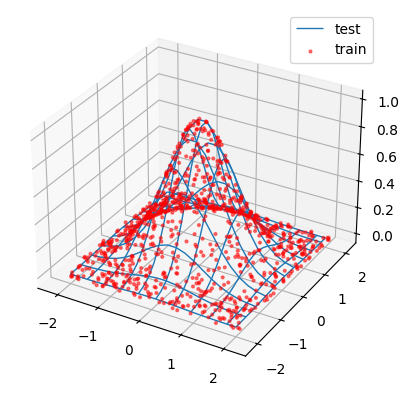

In [ ]:
# Reduce number of data to plot
sample_idx = np.random.choice(xtrain.shape[0], size=1000, replace=False) # replace=False : 중복없이
x_sample = xtrain[sample_idx]
y_sample = ytrain[sample_idx]

# Draw data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X1grid, X2grid, Ygrid, rstride=2, cstride=2, linewidth=1, label='test')
ax.scatter(x_sample[:, 0], x_sample[:, 1], y_sample.ravel(), s=4, c='r', marker='o', alpha=0.5, label='train') # x_sample[:, 0], x_sample[:, 1] -> 각 점의 x1, x2 좌표
ax.set_xlim([-2.5, +2.5])
ax.set_ylim([-2.5, +2.5])
ax.legend(loc='upper right')
plt.show()

###**Define the Feed-Forward Neural Network**

The feed-forward neural network is trained by minimizing the l2-loss-function:
$$ l(y, \hat{y}) = |y - \hat{y}|^2.$$

The gradients of network parameters are computed automatically in this code example.

In [ ]:
class MLP(nn.Module):
  def __init__(self, **kwargs):
    super(MLP, self).__init__() # 부모 클래스인 nn.Module의 생성자를 호출하여 내부 초기화를 수행
    self.__dict__.update(kwargs) # 넘겨받은 키워드 인자를 전부 self 객체의 속성으로 한 번에 저장
    self.dense1 = nn.Linear(self.dim_x, self.dim_h) # 첫 번째 완전연결층 정의
    self.dense2 = nn.Linear(self.dim_h, self.dim_h)
    self.dense3 = nn.Linear(self.dim_h, 1)
    self.tanh = nn.Tanh() # 활성화함수로 tanh 레이어 하나 생성

  def forward(self, x): # 순전파 메서드, 인자로 받은 입력 x가 이 함수 전체를 거쳐 출력 y로 변환
    h1 = self.tanh(self.dense1(x))
    h2 = self.tanh(self.dense2(h1))
    y = self.dense3(h2)
    return y

def compute_loss(y_true, y_pred): # 손실 함수
  loss = ((y_true - y_pred)**2).sum() # 합계 MSE 계산
  return loss

### **Train the Neural Network**

In [ ]:
def draw_procedure(X1grid, X2grid, Ygrid, x, ypred):
  """Draw learning procedure."""
  ypred = np.squeeze(ypred) # np.squeeze는 배열에서 크기가 1인 차원을 없애는 함수, # ypred가 (N,1)이면 (N,)으로 바꿔 줌
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_wireframe(X1grid, X2grid, Ygrid, rstride=2, cstride=2, linewidths=1.0, label='true')
  ax.scatter(x[:, 0], x[:, 1], ypred, s=10, c='m', alpha=0.5, marker='o', label='pred')
  ax.legend(loc='upper right')
  plt.show()

[   1] loss-train: 0.4337774/0.6670980, loss-test: 2.1964931


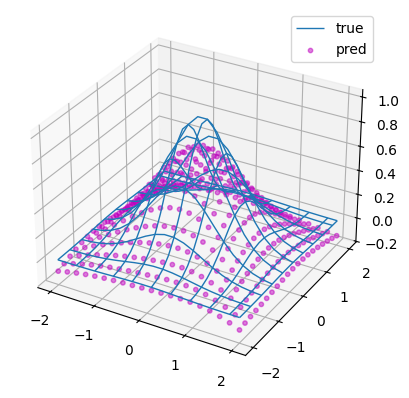

[  50] loss-train: 0.0012100/0.0009003, loss-test: 0.0100398


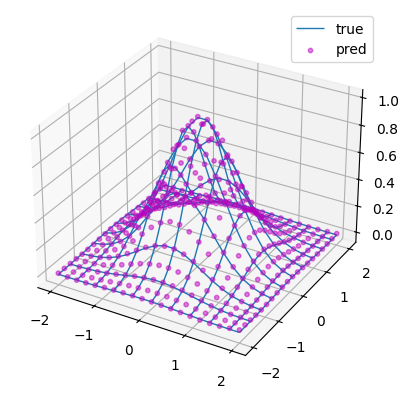

[ 100] loss-train: 0.0006883/0.0006414, loss-test: 0.0040481


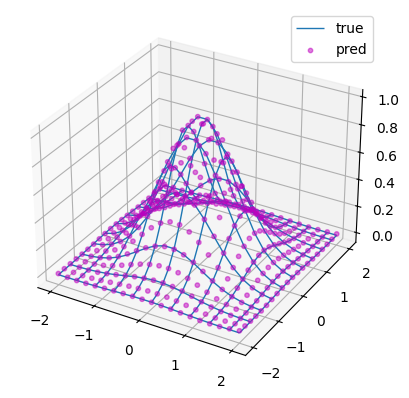

[ 150] loss-train: 0.0004765/0.0005427, loss-test: 0.0049717


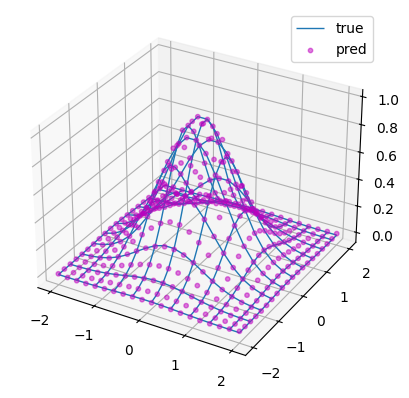

[ 200] loss-train: 0.0004716/0.0005636, loss-test: 0.0027656


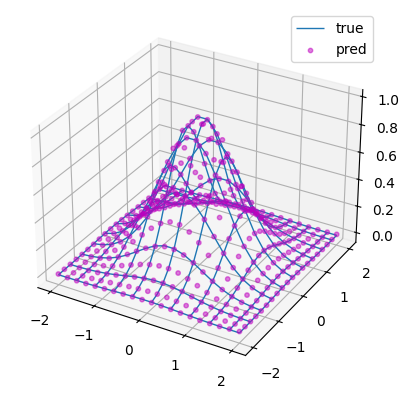

[ 250] loss-train: 0.0002695/0.0003520, loss-test: 0.0028238


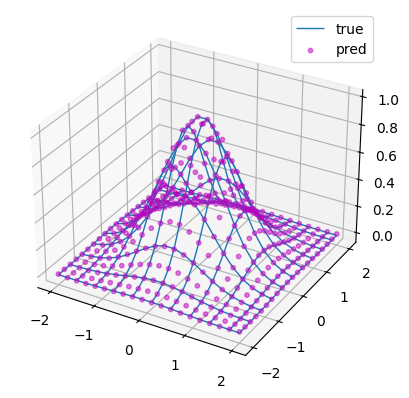

[ 300] loss-train: 0.0003441/0.0013242, loss-test: 0.0019949


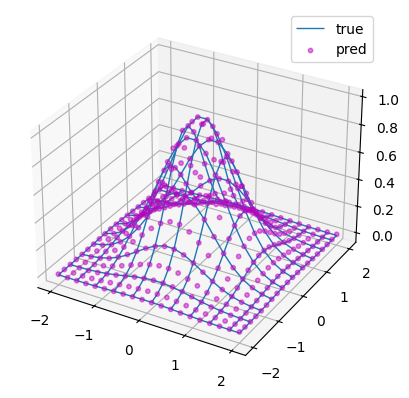

In [ ]:
epochs = 300
batchsize = 25
learningrate = 5e-3
displaystep = 50 # 몇 에폭마다 결과를 보여줄지
dim_x = 2
dim_h = 64

traindata_torch = TensorDataset(torch.from_numpy(xtrain),torch.from_numpy(ytrain))
dataloader = DataLoader(dataset=traindata_torch, batch_size=batchsize, shuffle=True)
xtest_torch = torch.from_numpy(xtest)

mlp = MLP(dim_x=dim_x, dim_h=dim_h) # nn.Module 상속 MLP 인스턴스
optimizer = optim.SGD(mlp.parameters(), lr=learningrate) # SGD 옵티마이저
loss_list = [] # 에폭별 학습 손실 기록용
for epoch in range(epochs):
    _loss = [] # 이 에폭의 배치별 손실을 담을 리스트
    for (x, y) in dataloader: # DataLoader에서 미니배치(x,y) 추출
      x, y = x.float().to(device), y.float().to(device) # float32로 변환 후 GPU/CPU(device)로 이동
      ypred = mlp.forward(x) # 순전파: 예측값 계산
      loss = compute_loss(y, ypred)  # 손실 계산 (sum of squared errors)
      optimizer.zero_grad() # 이전 기울기 초기화
      loss.backward() # 역전파로 gradient 계산
      optimizer.step() # 옵티마이저로 가중치 갱신

      _loss.append(loss.item()) # Python float로 뽑아 리스트에 저장

    _l_mean = np.mean(_loss) # 배치 손실 평균
    _l_std = np.std(_loss) # 배치 손실 표준편차
    loss_list.append([_l_mean, _l_std])

    # 첫 에폭과 displaystep 간격일 때마다 테스트 평가 및 시각화
    if (epoch + 1) % displaystep == 0 or (epoch+1) in [1]:
      ypred_test = mlp(xtest_torch) # 테스트 입력으로 예측 (텐서)
      ypred_test = ypred_test.detach().cpu().numpy() # 그래디언트 분리 → CPU 복사 → NumPy 배열
      l_test = compute_loss(ytest, ypred_test) # NumPy 버전 손실 함수로 테스트 손실 계산
      print("[{:4d}] loss-train: {:3.7f}/{:3.7f}, loss-test: {:3.7f}"
          .format(epoch+1,_l_mean, _l_std, l_test))
      draw_procedure(X1grid, X2grid, Ygrid, xtest, ypred_test)

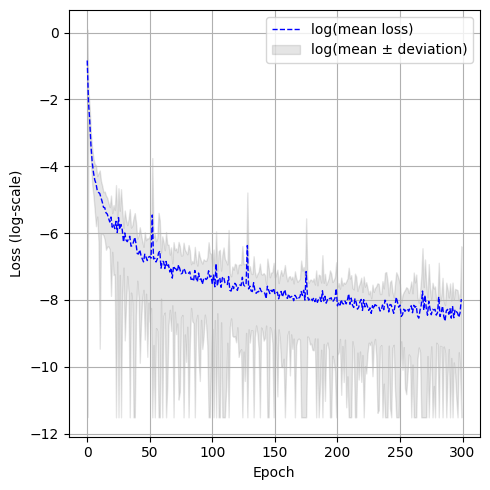

In [ ]:
loss_list = np.array(loss_list) # 이전 에폭별 [평균 손실, 표준편차]를 담은 파이썬 리스트를 NumPy 배열로 변환, shape = (epochs, 2)
plot_xrange = np.arange(loss_list.shape[0]) # x축에 사용할 에폭 인덱스 배열을 만듦, 0부터 (에폭 수 − 1)까지 연속된 정수
epsilon = 1e-5  # very small positive number

# log-conversion
l_mean = np.log(np.clip(loss_list[:, 0], epsilon, None)) # np.log를 적용해 로그 스케일 평균 손실을 구함
l_upper = np.log(np.clip(loss_list[:, 0] + loss_list[:, 1], epsilon, None)) # l_upper: 로그(평균 + 편차), l_lower: 로그(평균 − 편차), 에폭별 상·하한을 만듦
l_lower = np.log(np.clip(loss_list[:, 0] - loss_list[:, 1], epsilon, None))

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(plot_xrange, l_mean, 'b--', linewidth=1, label='log(mean loss)')
ax.fill_between(plot_xrange, l_lower, l_upper, color='k', alpha=0.1, label='log(mean ± deviation)')
ax.grid(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log-scale)')
ax.legend()

plt.tight_layout() # 레이블·축 제목·범례 등이 서로 겹치지 않도록 마진을 자동 조정
plt.show()